# 2020 Presidential Election Time Series
## Project Setup

In [7]:
%run get_data.py

Repo: 'origin': https://github.com/ElectProject/Early-Vote-2020G.git
Total commits: 1340
docs/index.html commits: 600


,commit,datetime,vote_id,vote_total,request_id,request_total
1,d4d22c502b202378e059b916ec2e3f4fbe37ae96,2020-11-01 20:37:00-05:00,total-voted,93297208,mail-ballots-requested,91210940
3,64ef8c2327df5b5668d275d3462a095ffa29cf9c,2020-11-01 16:22:00-05:00,total-voted,93254861,mail-ballots-requested,91210940
4,b93a031d65a30a91be8edb9283b0c1334d803348,2020-11-01 11:28:00-05:00,total-voted,93131017,mail-ballots-requested,91210603
5,51e4398cea3c81272483fad37013da557a044cb4,2020-11-01 10:32:00-05:00,total-voted,93322526,mail-ballots-requested,91215354
7,74c8d02e0d65fa06e9f99b2861d22a561823a458,2020-11-01 01:14:00-05:00,total-voted,92038417,mail-ballots-requested,91200986
...,...,...,...,...,...,...
595,55ef4d8da4c860460a99cff8d2e7dac0605a857d,2020-09-01 22:55:00-04:00,NaN,NaN,NaN,12743272
596,ff3f92d8e11b8a23335cddf64e5799c74912ec52,2020-09-01 22:08:00-04:00,NaN,NaN,NaN,12623324
597,52ba37e4bd3605ab83b71358536ddf26d54b395d,2020-09-01 20:43:00-04:00,NaN,NaN,national-statistics,12623324
598,d34181643d565305eff7486090acbe9329c48d31,2020-09-01 15:48:00-04:00,NaN,NaN,national-statistics,12623324


,datetime,vote_total_2016
0,2020-09-25 22:59:00-04:00,9525
1,2020-10-02 22:59:00-04:00,74836
2,2020-10-09 22:59:00-04:00,429337
3,2020-10-16 22:59:00-04:00,1400000
4,2020-10-23 22:59:00-04:00,5900000
5,2020-10-30 22:59:00-04:00,21000000
6,2020-11-02 22:59:00-05:00,46220922
7,2020-11-03 22:59:00-05:00,136452150


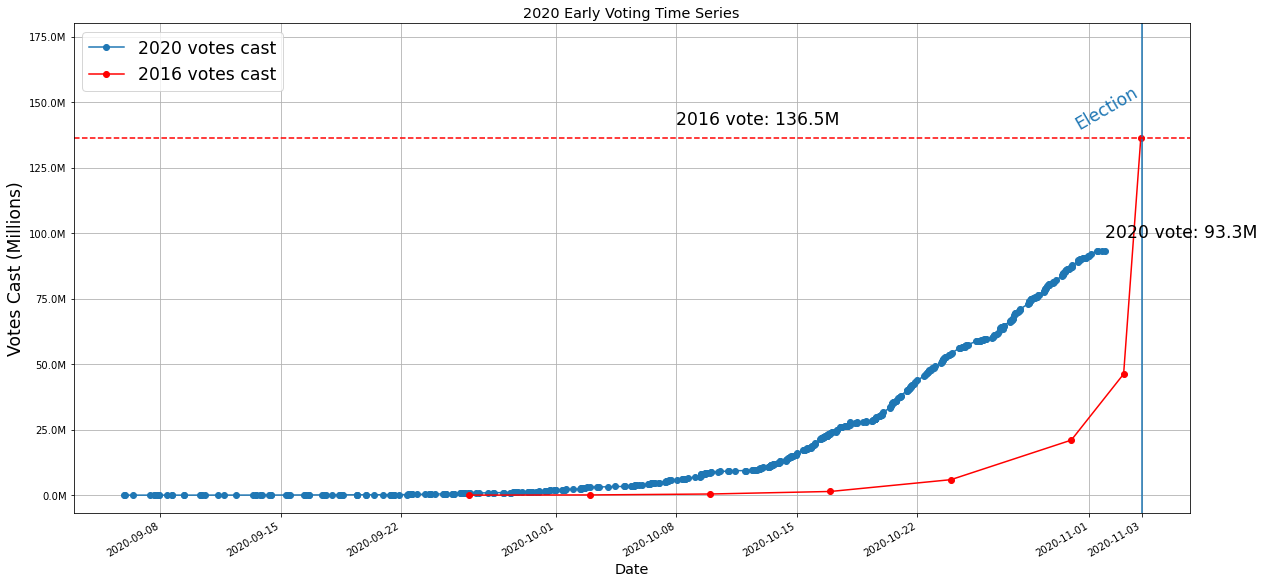

Loading BokehJS ...

In [8]:
update_notebook()